<a href="https://colab.research.google.com/github/vn322/RUDN_Lab_Works/blob/main/22_03_2025_%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BF%D0%BE%D0%BB%D1%8F%D1%86%D0%B8%D1%8F_%D0%B8_%D1%81%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

from typing import Callable, Tuple, List

## 3.1
Используя таблицу значений $Y_i$ функции $y = f(x)$, вычисленных в точках $X_i, i=0,...,3$ построить интерполяционные многочлены Лагранжа и Ньютона, проходящие через точки $\{X_i, Y_i\}$. Вычислить значение погрешности интерполяции в точке $X^\ast$.



In [28]:
def Lagrange_interpolation_polynomial(f: Callable, x_coordinates: tuple) -> Callable:
    ''' Returns Lagrange polynomial function for a given function f calculated at points with x_coordinates '''

    def lagrange_poly(x):
        points = list(zip(x_coordinates, list(map(f, x_coordinates))))

        l = []
        for i in range(len(points)):
            l.append(np.prod([(x - points[j][0]) / (points[i][0] - points[j][0])
                              for j in range(len(points)) if i != j]))
        return sum([points[idx][1] * i for idx, i in enumerate(l)])

    return lagrange_poly


def Newton_interpolation_polynomial(f: Callable, x_coordinates: tuple) -> Callable:
    ''' Returns Newton polynomial function for a given function f calculated at points with x_coordinates '''

    def divided_diff(x, y):
        ''' Function to calculate the table of divided differences. '''
        n = len(y)
        coef = np.zeros([n, n])
        coef[:,0] = y

        for j in range(1,n):
            for i in range(n-j):
                coef[i][j] = (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j]-x[i])

        return coef

    def newton_poly(x):
        ''' Evaluate the newton polynomial at x '''

        # take the first row of the divided difference table
        div_diff = divided_diff(x_coordinates, list(map(f, x_coordinates)))[0, :]

        n = len(x_coordinates) - 1
        p = div_diff[n]
        for k in range(1, n + 1):
            p = div_diff[n - k] + (x - x_coordinates[n - k]) * p
        return p

    return newton_poly


if __name__ == '__main__':

    f1 = math.tan
    p = np.pi
    x_coordinates_a = (0, p/8, 2*p/8, 3*p/8)
    x_coordinates_b = (0, p/8, p/3, 3*p/8)
    x_star = 3*p/16

    Lagrange_polynomial_a = Lagrange_interpolation_polynomial(f, x_coordinates_a)
    Newton_polynomial_a = Newton_interpolation_polynomial(f, x_coordinates_a)
    print('a)')
    print(f'Lagrange polynomial at x =  3*p/16: {Lagrange_polynomial_a(x_star)}, absolute error: {abs(f(x_star) - Lagrange_polynomial_a(x_star))}')
    print(f'Newton polynomial at x =  3*p/16: {Newton_polynomial_a(x_star)}, absolute error: {abs(f(x_star) - Newton_polynomial_a(x_star))}')
    print(f'arctg(x) at x =  3*p/16: {f(x_star)}')

    Lagrange_polynomial_b = Lagrange_interpolation_polynomial(f, x_coordinates_b)
    Newton_polynomial_b = Newton_interpolation_polynomial(f, x_coordinates_b)
    print('\nb)')
    print(f'Lagrange polynomial at x =  3*p/16: {Lagrange_polynomial_b(x_star)}, absolute error: {abs(f(x_star) - Lagrange_polynomial_b(x_star))}')
    print(f'Newton polynomial at x =  3*p/16: {Newton_polynomial_b(x_star)}, absolute error: {abs(f(x_star) - Newton_polynomial_b(x_star))}')
    print(f'arctg(x) at x =  3*p/16: {f(x_star)}')

a)
Lagrange polynomial at x =  3*p/16: 0.6446067811865475, absolute error: 0.023571856732751417
Newton polynomial at x =  3*p/16: 0.6446067811865475, absolute error: 0.023571856732751417
arctg(x) at x =  3*p/16: 0.6681786379192989

b)
Lagrange polynomial at x =  3*p/16: 0.585250828828199, absolute error: 0.08292780909109987
Newton polynomial at x =  3*p/16: 0.5852508288281993, absolute error: 0.08292780909109954
arctg(x) at x =  3*p/16: 0.6681786379192989


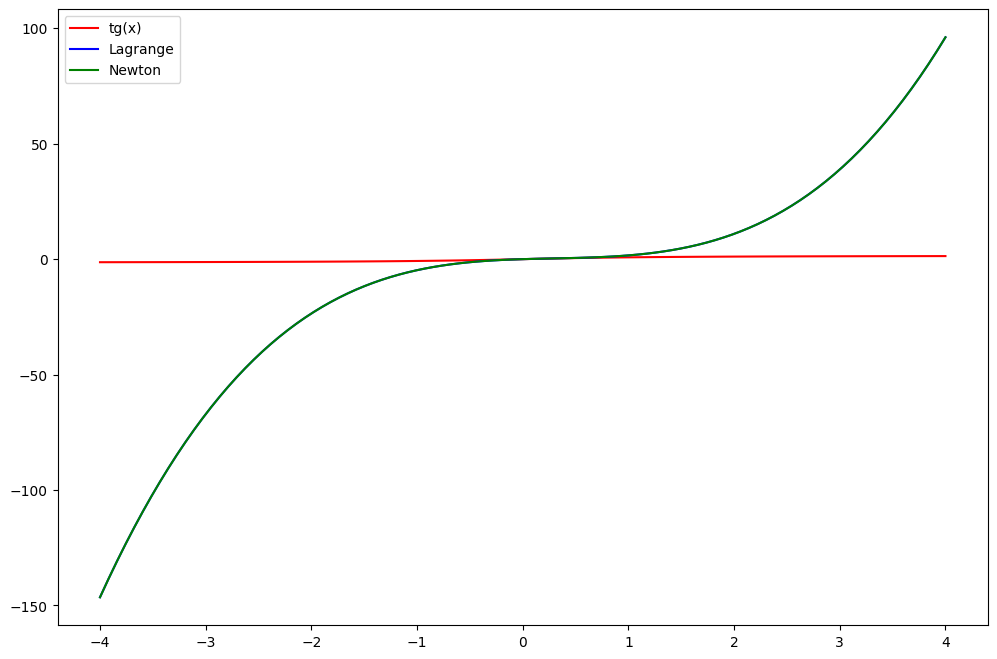

In [35]:
x = np.linspace(-4, 4, num=100)
plt.figure(figsize=(12, 8))
plt.plot(x, np.arctan(x), color='red', label='tg(x)')
plt.plot(x, list(map(Lagrange_polynomial_a, x)), color='blue', label='Lagrange')
plt.plot(x, list(map(Newton_polynomial_a, x)), color='Green', label='Newton')
plt.legend()
plt.show()

## 3.2

Построить кубический сплайн для функции, заданной в узлах интерполяции,
предполагая, что сплайн имеет нулевую кривизну при $x = x_0$ и $x = x_4$. Вычислить
значение функции в точке $x = X^\ast$.

In [29]:
def tri_diagonal_matrix_algorithm(matrix: list, d: list, shape: int) -> list:
    ''' Solve the system of linear equations using the tri-diagonal matrix algorithm. '''
    a, b, c = zip(*matrix)
    p = [-c[0] / b[0]]
    q = [d[0] / b[0]]
    x = [0] * (shape + 1)
    for i in range(1, shape):
        p.append(-c[i] / (b[i] + a[i] * p[i - 1]))
        q.append((d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1]))

    for i in reversed(range(shape)):
        x[i] = p[i] * x[i + 1] + q[i]

    return x[:-1]


def spline(x: list, f: list) -> List[list]:
    ''' Returns 4 lists of the cubic spline coefficients that interpolate the function f for given x coordinates '''
    n = len(x)
    h = [x[i] - x[i - 1] for i in range(1, n)]
    tridiag_matrix = [[0, 2 * (h[0] + h[1]), h[1]]]
    b = [3 * ((f[2] - f[1]) / h[1] - (f[1] - f[0]) / h[0])]
    for i in range(1, n - 3):
        tridiag_row = [h[i], 2 * (h[i] + h[i + 1]), h[i + 1]]
        tridiag_matrix.append(tridiag_row)
        b.append(3 * ((f[i + 2] - f[i + 1]) / h[i + 1] - (f[i + 1] - f[i]) / h[i]))

    tridiag_matrix.append([h[-2], 2 * (h[-2] + h[-1]), 0])
    b.append(3 * ((f[-1] - f[-2]) / h[-1] - (f[-2] - f[-3]) / h[-2]))

    c = tri_diagonal_matrix_algorithm(tridiag_matrix, b, n - 2)
    a = []
    b = []
    d = []
    c.insert(0, 0)
    for i in range(1, n):
        a.append(f[i - 1])
        if i < n - 1:
            d.append((c[i] - c[i - 1]) / (3 * h[i - 1]))
            b.append((f[i] - f[i - 1]) / h[i - 1] - h[i - 1] * (c[i] + 2 * c[i - 1]) / 3)

    b.append((f[-1] - f[-2]) / h[-1] - 2 * h[-1] * c[-1] / 3)
    d.append(-c[-1] / (3 * h[-1]))
    return a, b, c, d


def interpolate(x: list, x_0: float, coef: list) -> float:
    ''' Use the cubic spline to return the estimate of f(x_0). '''

    k = 0
    for i, j in zip(x, x[1:]):
        if i <= x_0 <= j:
            break
        k += 1

    a, b, c, d = coef
    diff = x_0 - x[k]
    return a[k] + b[k] * diff + c[k] * diff ** 2 + d[k] * diff ** 3


if __name__ == '__main__':
    x = [0, 0.9, 1.8, 2.7, 3.6]
    f = [0, -0.72235, 1.5609, 2.8459, 7.7275]
    x_star = 1.5

    coef = spline(x, f)
    a, b, c, d = coef
    res = interpolate(x, x_star, coef)

    for i in range(len(x) - 1):
        print(f'[{x[i]}, {x[i + 1]}] : f_{i}(x) = {a[i]} + {b[i]}(x-({x[i]})) + {c[i]}(x-({x[i]}))^2 + {d[i]}(x-({x[i]}))^3\n')

    print('x* = ', x_star)
    print('f(x*) = ', res, end='\n\n\n')

[0, 0.9] : f_0(x) = 0 + -1.847722222222222(x-(0)) + 0(x-(0))^2 + 1.2902606310013713(x-(0))^3

[0.9, 1.8] : f_1(x) = -0.72235 + 1.2876111111111113(x-(0.9)) + 3.4837037037037026(x-(0.9))^2 + -2.3283950617283944(x-(0.9))^3

[1.8, 2.7] : f_2(x) = 1.5609 + 1.9002777777777766(x-(1.8)) + -2.8029629629629627(x-(1.8))^2 + 2.5310699588477372(x-(1.8))^3

[2.7, 3.6] : f_3(x) = 2.8459 + 3.005444444444445(x-(2.7)) + 4.030925925925928(x-(2.7))^2 + -1.4929355281207142(x-(2.7))^3

x* =  1.5
f(x*) =  0.8014166666666663




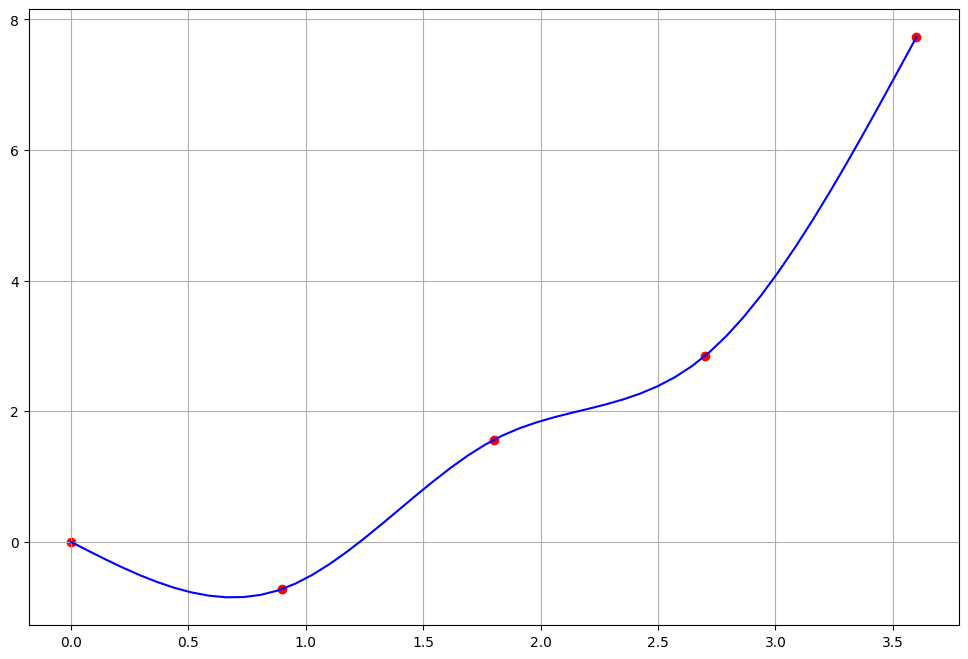

In [30]:
x_vals = np.linspace(x[0], x[-1])
y = [interpolate(x, val, coef) for val in x_vals]
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y, color='b')
plt.scatter(x, f, color='r')
plt.grid()

## 3.4

Вычислить первую и вторую производную от таблично заданной функции $y_i = f(x_i), i=0,...,4$ в точке $x = X^\ast$.

In [31]:
def get_first_derivative(x: list, y: list, seg_num: int) -> float:
    ''' Get the first derivative of a point-defined function in a particular segment. '''

    return (y[seg_num + 1] - y[seg_num])/(x[seg_num + 1] - x[seg_num])


def get_second_derivative(x: list, y: list, seg_num: int) -> float:
    ''' Get the second derivative of a point-defined function in a particular segment. '''

    return 2*(get_first_derivative(x, y, segment_num + 1) - get_first_derivative(x, y, segment_num))/\
           (x[seg_num+2] - x[seg_num])


if __name__ == "__main__":
    x = [1, 2, 3, 4, 5]
    y = [1, 2.6931, 4.0986, 5.3863, 6.6094]
    X = 3

    segment_num = -1
    i = 0
    while i + 1 < len(x) and x[i + 1] < X:
        i += 1

    segment_num = i
    print("Номер отрезка:", segment_num)

    if segment_num + 1 < len(x):
        if X == x[segment_num + 1]:
            if 0 < segment_num < len(x) - 2:
                left_derivative = get_first_derivative(x, y, segment_num)
                right_derivative = get_first_derivative(x, y, segment_num + 1)
                print(f'Левосторонняя производная: {left_derivative}')
                print(f'Правостороняя производная: {right_derivative}')
                derivative = (right_derivative + left_derivative) / 2
                print(f'Первая производная со вторым порядком точности: {derivative}')
                second_derivative = get_second_derivative(x, y, segment_num)
                print(f'Вторая производная: {second_derivative}')
            else:
                print('Краевая точка, производная не определена')
                exit()
        else:
            derivative = get_first_derivative(x, y, segment_num)
            print(f'Первая производная: {derivative}')
            if segment_num + 2 < len(x):
                second_derivative = get_second_derivative(x, y, segment_num)
                print(f'Вторая производная: {second_derivative}')

Номер отрезка: 1
Левосторонняя производная: 1.4055000000000004
Правостороняя производная: 1.2877
Первая производная со вторым порядком точности: 1.3466000000000002
Вторая производная: -0.11780000000000035


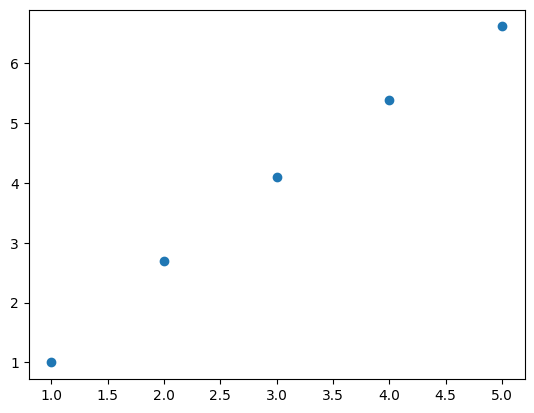

In [32]:
plt.scatter(x, y)

## 3.5

Вычислить определенный интеграл $F = \int_{x_0}^{x_k} y \,dx$ методами прямоугольников, трапеций, Симпсона с шагами $h_1, h_2$. Оценить погрешность вычислений, используя метод Рунге-Ромберга.

In [33]:
def rectangle_method(interval: list, f: Callable, h: float) -> float:
    '''
        Estimate the integral of the function f within given interval and step h
        using rectangle method.
    '''

    a, b = interval
    x = np.linspace(a, b, int((b - a) / h + 1))
    I = h * sum([f((i + j) / 2) for i, j in zip(x, x[1:])])
    return I


def trapezium_method(interval: list, f: Callable, h: float) -> float:
    '''
        Estimate the integral of the function f within given interval and step h
        using trapezium method.
    '''

    a, b = interval
    x = np.linspace(a, b, int((b - a) / h + 1))
    y = [f(i) for i in x]

    I = h / 2 * sum([f_i + f_j for f_i, f_j in zip(y[1:], y)])
    return I


def Simpson_method(interval: list, f: Callable, h: float) -> float:
    '''
        Estimate the integral of the function f within given interval and step h
        using Simpson's method.
    '''

    a, b = interval
    n = int((b - a) / h + 1)

    odd = 4 * np.sum([f(a + i * h) for i in range(1, n, 2)])
    even = 2 * np.sum([f(a + i * h) for i in range(2, n - 1, 2)])
    I = h / 3 * (f(a) + odd + even + f(b))
    return I


def Runge_Romberg(I_fh: float, I_fkh: float, k: float, p: float) -> float:
    '''
        Calculate the Runge-Romberg error of integration with method of order p.
        I_fh, I_fkh -- integrals calculated with step h1 and h2 respectively.
        k = h1 / h2.
    '''

    return I_fh + (I_fh - I_fkh) / (k**p - 1)


if __name__ == '__main__':
    interval = [0, 2]
    h = [0.5, 0.25]
    f = lambda x: x / (x**4 + 16)

    methods = {
        'Rectangle method' : [rectangle_method, 1],
        'Trapezium method' : [trapezium_method, 2],
        'Simpson\'s method' : [Simpson_method, 4]
    }

    for method_name, method in methods.items():
        for i in range(len(h)):
            print(f'{method_name} with h = {h[i]}: {method[0](interval, f, h[i])}')
        print(f'Runge-Romberg error: {Runge_Romberg(method[0](interval, f, h[0]), method[0](interval, f, h[1]), h[0] / h[1], method[1])}', end='\n\n')


Rectangle method with h = 0.5: 0.09916217116456566
Rectangle method with h = 0.25: 0.09841958136303793
Runge-Romberg error: 0.0999047609660934

Trapezium method with h = 0.5: 0.09620927564585395
Trapezium method with h = 0.25: 0.09768572340520981
Runge-Romberg error: 0.09571712639273533

Simpson's method with h = 0.5: 0.09825452439055035
Simpson's method with h = 0.25: 0.09817787265832842
Runge-Romberg error: 0.09825963450603181



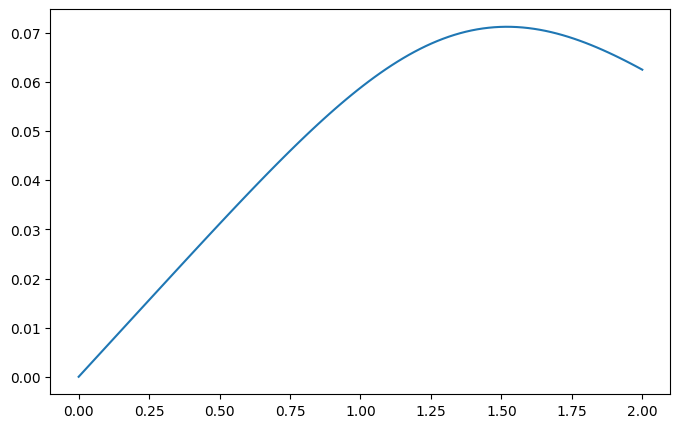

In [34]:
plt.figure(figsize=(8, 5))
x = np.linspace(*interval, 100)
plt.plot(x, list(map(f, x)))